<a href="https://colab.research.google.com/github/AdamClarkStandke/TinyMachineLearning/blob/main/GestureModelTraining_TFliteConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup env
!apt-get -qq install xxd
!pip install pandas numpy matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "upper_cut.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (10,5)
fig = plt.figure()
# plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
# plt.title("Acceleration")
# plt.xlabel("Sample #")
# plt.ylabel("Acceleration (G)")
# plt.legend()
# plt.tight_layout()
# plt.savefig('upper_accel.jpg')
# plt.show()


plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.tight_layout()
plt.savefig('upper_gyro.jpg')
plt.show()

In [43]:
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "punch",
    "upper_cut",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.11.0

Processing index 0 for gesture 'punch'.
	There are 17 recordings of the punch gesture.
Processing index 1 for gesture 'upper_cut'.
	There are 18 recordings of the upper_cut gesture.
Data set parsing and preparation complete.


In [48]:
print(inputs.shape)
print(outputs.shape)

(35, 714)
(35, 2)


In [50]:
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [57]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=300, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Epoch 1/300
21/21 [==============================] - 1s 12ms/step - loss: 0.3274 - mae: 0.5055 - val_loss: 0.2351 - val_mae: 0.4847
Epoch 2/300
21/21 [==============================] - 0s 10ms/step - loss: 0.2545 - mae: 0.4892 - val_loss: 0.3437 - val_mae: 0.5798
Epoch 3/300
21/21 [==============================] - 0s 7ms/step - loss: 0.2540 - mae: 0.4960 - val_loss: 0.3450 - val_mae: 0.5807
Epoch 4/300
21/21 [==============================] - 0s 6ms/step - loss: 0.2459 - mae: 0.4824 - val_loss: 0.3588 - val_mae: 0.5905
Epoch 5/300
21/21 [==============================] - 0s 5ms/step - loss: 0.2505 - mae: 0.4887 - val_loss: 0.3324 - val_mae: 0.5707
Epoch 6/300
21/21 [==============================] - 0s 5ms/step - loss: 0.2531 - mae: 0.4938 - val_loss: 0.3184 - val_mae: 0.5597
Epoch 7/300
21/21 [==============================] - 0s 4ms/step - loss: 0.2174 - mae: 0.4410 - val_loss: 0.1853 - val_mae: 0.4255
Epoch 8/300
21/21 [==============================] - 0s 5ms/step - loss: 0.2514 -

In [60]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (1, 50)                   35750     
                                                                 
 dense_4 (Dense)             (1, 15)                   765       
                                                                 
 dense_5 (Dense)             (1, 2)                    32        
                                                                 
Total params: 36,547
Trainable params: 36,547
Non-trainable params: 0
_________________________________________________________________


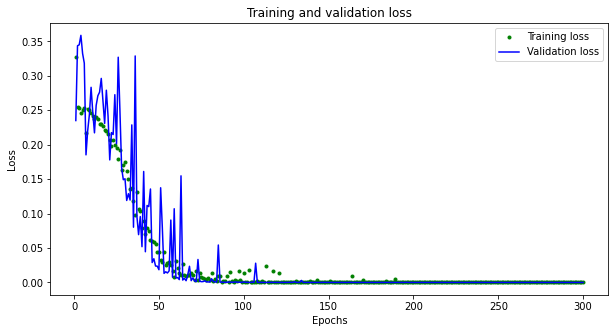

[10.0, 5.0]


In [61]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (10,5)
fig = plt.figure()

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training_val_loss_.jpg')
plt.show()

print(plt.rcParams["figure.figsize"])

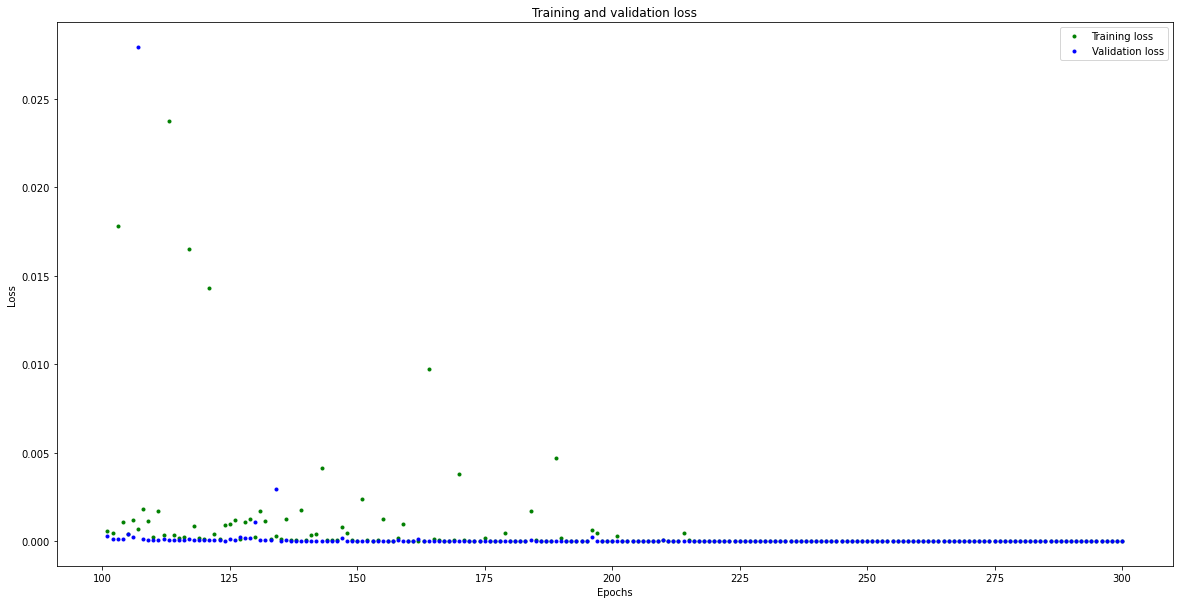

In [59]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

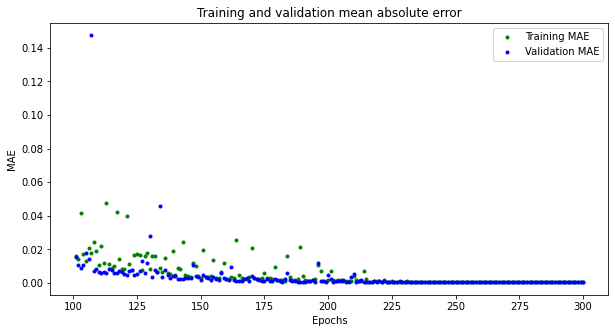

In [62]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [67]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)


1/1 [==============================] - 0s 34ms/step
predictions =
 [[0.001 0.999]
 [1.    0.   ]
 [0.002 0.998]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.001 0.999]]
actual =
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [68]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  

Model is 148312 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [69]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 914,626 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
